# Initialize Parameters

In [1]:
# !pip3 install pandas==0.25.1
import os

import pandas as pd
import numpy as np
import scipy
from time import time

# import argparse
# import configparser
import json
from pandas.io.json import json_normalize
import pickle
import datetime 
import matplotlib.pyplot as plt
from IPython.display import display
# %matplotlib notebook
%matplotlib inline


import warnings 
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

#import copy
#import h5py
import gc

import crack, utils


In [2]:
# set folder
#folder = 'data'

# [Elasticity]
E = 71.7e9 # Young's modulus of the material (here: 7075-T6 aluminium alloy)
nu = 0.33 # Poisson's ratio of the material (here: 7075-T6 aluminium alloy)

# [GaugePlacement]
x_gauge = 0.003, 0.014, 0.025 
y_gauge = 0.014, 0.014, 0.014
nb_gauges = 3
theta_gauge = 45 
#choisies minutieusement après avoir examiné obtenus en fonction de la distance :
# + la distance avec la fissure est grande et - d'informations on a : useless
#orientation : plus langle est proche de 0, plus la fluctuation des signaux est importante : + sensibles aux fissures

# [CrackData]
a_0_mean = 0.001 # Half crack length mean in [m]
a_0_std = a_0_mean*0.125 #0.0008 # Standard deviation of a_0 corresponding to a CoV of 0.35
C_mean = 1e-10 # Value of Paris law constant C representing its log mean (exp(mean(log(C))))
C_std = C_mean*(8e3-1)/(2+2*8e3) #rapport 95%
# log_C_std = np.log(1+ (C_std**2)/(C_mean**2))
# log_C_std = 2.292652250168871 # Standard deviation of the log of C    np.log(8000)/4#
m_mean = 3.5 # Paris law exponent
m_std = 0.125#10204081633 # Standard deviation of Paris law exponent (1/1.96, correspondig to having 95% confidence interval at +- 1



# [Load]
K_IC = 19.7 #ténacité et vaut pour un alliage d’Aluminium 19.7 MPa*m^0.5
sigma_inf = 78.6e6 
sigma_0 = 0 # Minimum load in MPa
delta_sigma = sigma_inf-sigma_0 # Difference between maximum and minimum load in MPa
a_crit = (K_IC/(delta_sigma*1e-6*np.sqrt(np.pi)))**2  #(half) crack size at failure time T


# [Sampling]
n_train = 1000 # Number of "experiments" for training
n_validation = 100 # Number of "experiments" for validation
n_test = 100# Number of "experiments" for testing

#other parameters
thinning = 500 # Take values only every `thinning` cycles
lb_tstar = 0.33 #lower boundary
ub_tstar = 0.95 #upper boundary



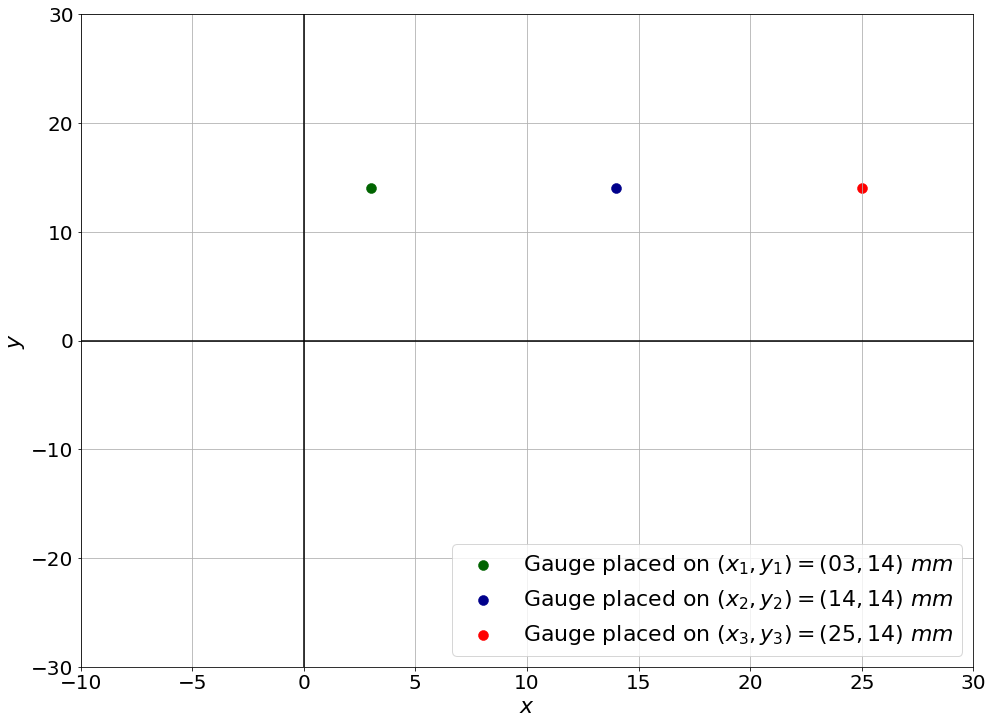

In [3]:
plt.figure(figsize=(16, 12))
plt.rcParams.update({'font.size':22})
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.scatter(np.array(x_gauge)[0]*1000, np.array(y_gauge)[0]*1000,marker='o',   s=100, c = 'darkgreen',cmap='viridis', linewidth=0.5, label = 'Gauge placed on $(x_1,y_1) = (03,14) ~ mm$' )
plt.scatter(np.array(x_gauge)[1]*1000, np.array(y_gauge)[1]*1000,marker='o',   s=100, c = 'darkblue',cmap='viridis', linewidth=0.5, label = 'Gauge placed on $(x_2,y_2) = (14,14)~ mm$')
plt.scatter(np.array(x_gauge)[2]*1000, np.array(y_gauge)[2]*1000,marker='o',   s=100, c = 'red',cmap='viridis', linewidth=0.5, label = 'Gauge placed on $(x_3,y_3) = (25,14)~ mm$')

# plt.plot(np.array(x_gauge)*1000, np.array(y_gauge)*1000,marker='o')
plt.legend(loc = 'lower right')
plt.grid()
plt.vlines(0,-30,30)
plt.hlines(0,-30,30)
plt.ylim(-30,30)
plt.xlim(-10,30)
plt.xlabel('$x$')
plt.ylabel('$y$')
# plt.legend()



plt.show()

# Generate dataset & save

In [3]:
# from numba import jit

print('\nTraining set:')
training_set = gen_func.gen_dataset('train', x_gauge, y_gauge, theta_gauge, delta_sigma, E, nu, a_0_mean, a_0_std, a_crit, C_mean, C_std, m_mean, m_std, n_train, thinning)
# training_set.to_pickle('training_set_thinning500', protocol = pickle.HIGHEST_PROTOCOL)
# del(training_set)
gc.collect()

print('\nValidation set:')
validation_set = gen_func.gen_dataset('train', x_gauge, y_gauge, theta_gauge, delta_sigma, E, nu, a_0_mean, a_0_std, a_crit, C_mean, C_std, m_mean, m_std, n_train, thinning)
# validation_set.to_pickle('validation_set_thinning500', protocol = pickle.HIGHEST_PROTOCOL)
# del(training_set)
gc.collect()


print('\nTest set:')
test_set = gen_func.gen_dataset('test', x_gauge, y_gauge, theta_gauge, delta_sigma, E, nu, a_0_mean, a_0_std,a_crit, C_mean, C_std, m_mean, m_std, n_test, thinning)
test_set['t_star'] = 0 #t* which is the size of the sequence (in number of cycles) available for the testing set
test_set['t_star'] = (np.random.uniform(low=lb_tstar, high=ub_tstar, size=(test_set.shape[0],)) * test_set.nb_cycles.values).astype(int)
# test_set.to_pickle('test_set_thinning500', protocol = pickle.HIGHEST_PROTOCOL)
# del(test_set)
gc.collect()


Training set:
Created dataset no.  1 with  61500 cycles
Created dataset no.  2 with  77000 cycles
Created dataset no.  3 with  64000 cycles
Created dataset no.  4 with  74000 cycles
Created dataset no.  5 with  74000 cycles
Created dataset no.  6 with  66000 cycles
Created dataset no.  7 with  72000 cycles
Created dataset no.  8 with  74500 cycles
Created dataset no.  9 with  58500 cycles
Created dataset no.  10 with  59500 cycles
Created dataset no.  11 with  59000 cycles
Created dataset no.  12 with  65000 cycles
Created dataset no.  13 with  67000 cycles
Created dataset no.  14 with  72000 cycles
Created dataset no.  15 with  70000 cycles
Created dataset no.  16 with  60000 cycles
Created dataset no.  17 with  64000 cycles
Created dataset no.  18 with  62500 cycles
Created dataset no.  19 with  70500 cycles
Created dataset no.  20 with  69500 cycles
Created dataset no.  21 with  63000 cycles
Created dataset no.  22 with  66000 cycles
Created dataset no.  23 with  71000 cycles
Creat

0

In [4]:
utils.gen_dataset('test', x_gauge, y_gauge, theta_gauge, delta_sigma, E, nu, a_0_mean, a_0_std,a_crit, C_mean, C_std, m_mean, m_std, n_test, thinning).to_pickle('tt', protocol = pickle.HIGHEST_PROTOCOL)

Created dataset no.  1 with  68000 cycles
Created dataset no.  2 with  62000 cycles
Created dataset no.  3 with  69500 cycles
Created dataset no.  4 with  71500 cycles
Created dataset no.  5 with  73000 cycles
Created dataset no.  6 with  68500 cycles
Created dataset no.  7 with  69500 cycles
Created dataset no.  8 with  72000 cycles
Created dataset no.  9 with  72500 cycles
Created dataset no.  10 with  65000 cycles
Created dataset no.  11 with  60000 cycles
Created dataset no.  12 with  69500 cycles
Created dataset no.  13 with  72500 cycles
Created dataset no.  14 with  66500 cycles
Created dataset no.  15 with  64000 cycles
Created dataset no.  16 with  68500 cycles
Created dataset no.  17 with  63000 cycles
Created dataset no.  18 with  70500 cycles
Created dataset no.  19 with  64000 cycles
Created dataset no.  20 with  64000 cycles
Created dataset no.  21 with  67000 cycles
Created dataset no.  22 with  67500 cycles
Created dataset no.  23 with  76000 cycles
Created dataset no. 

In [25]:
pd.read_pickle('raw_train_noise').ix[9900:,:9].reset_index().ix[:,1:].to_pickle('validation_set_thinning500', protocol = pickle.HIGHEST_PROTOCOL)

In [26]:
pd.read_pickle('validation_set_thinning500')

,C,m,a_0,x_gauges,y_gauges,crack_lengths,nb_cycles,Nb_measures,strains
0,9.245385e-11,3.465963,0.001086,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010858365815287025, 0.0010950010822167327,...",71790,144,"[[0.0006847323267683005, 0.0006928887838668859..."
1,7.743287e-11,3.585115,0.001038,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010378934660859606, 0.001046381872230308, ...",70253,141,"[[0.000685516509665119, 0.0006929758210099065,..."
2,6.694084e-11,3.657135,0.001157,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.001157239337596423, 0.0011672216492946226, ...",63859,128,"[[0.0006835010644519613, 0.000692751398600429,..."
3,9.831128e-11,3.424800,0.001015,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010149339633133108, 0.0010230835287769586,...",77481,155,"[[0.0006858798902830042, 0.0006930160313141147..."
4,8.196107e-11,3.547929,0.001055,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010547567716928784, 0.001063500311359385, ...",70452,141,"[[0.0006852445939094051, 0.0006929456815098654..."
...,...,...,...,...,...,...,...,...,...
95,6.957963e-11,3.650142,0.001170,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0011697622995528942, 0.0011802323626036368,...",61698,124,"[[0.0006832773380735308, 0.0006927263394194854..."
96,6.028603e-11,3.712726,0.001088,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010883135915199487, 0.0010970559238508272,...",67172,135,"[[0.0006846908808684127, 0.0006928841737518269..."
97,6.355606e-11,3.688883,0.001080,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010796425361933688, 0.0010883999809912415,...",67290,135,"[[0.0006848355672636696, 0.0006929002631563309..."
98,1.271580e-10,3.313336,0.001038,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010381101356978885, 0.0010473827733604184,...",73565,148,"[[0.0006855130428749246, 0.0006929754370177063..."


# Load set

In [27]:
# every 500 cycles
training_set = pd.read_pickle('training_set_thinning500')
validation_set = pd.read_pickle('validation_set_thinning500')
test_set = pd.read_pickle('test_set_thinning500')

In [48]:
training_set

,C,m,a_0,x_gauges,y_gauges,crack_lengths,nb_cycles,Nb_measures,strains
0,9.553243e-11,3.467495,0.001109,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0011090514315192936, 0.0011189016013621717,...",68053,137,"[[0.0006843403111726386, 0.0006928451389166603..."
1,8.937007e-11,3.506766,0.001031,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.001030909496610769, 0.0010395166124785935, ...",71496,143,"[[0.0006856278797196855, 0.0006929881529677297..."
2,1.043560e-10,3.425026,0.001092,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010917713479590108, 0.0011015848735838176,...",68762,138,"[[0.0006846328722376829, 0.0006928777196412354..."
3,8.416821e-11,3.547992,0.001127,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.001126880006600319, 0.0011369838295346756, ...",64782,130,"[[0.0006840338165750021, 0.0006928109526953373..."
4,6.011834e-11,3.709197,0.001010,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010098830873455325, 0.0010174272141869267,...",72714,146,"[[0.0006859587716782937, 0.0006930247498699801..."
...,...,...,...,...,...,...,...,...,...
995,8.099555e-11,3.545623,0.001111,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.001110918915348389, 0.0011203605728820807, ...",68482,137,"[[0.0006843084280526095, 0.0006928415852598026..."
996,7.838738e-11,3.560569,0.001029,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010289627749978459, 0.001037116198005991, ...",73396,147,"[[0.0006856587931720195, 0.0006929915747192918..."
997,9.147314e-11,3.503093,0.001031,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010307906298151952, 0.0010395512484050698,...",70370,141,"[[0.0006856297689195943, 0.0006929883620956676..."
998,8.838716e-11,3.526817,0.001138,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0011380165512468346, 0.001148466984479796, ...",63838,128,"[[0.0006838399746300619, 0.0006927893032273157..."


In [49]:
validation_set

,C,m,a_0,x_gauges,y_gauges,crack_lengths,nb_cycles,Nb_measures,strains
0,9.245385e-11,3.465963,0.001086,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010858365815287025, 0.0010950010822167327,...",71790,144,"[[0.0006847323267683005, 0.0006928887838668859..."
1,7.743287e-11,3.585115,0.001038,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010378934660859606, 0.001046381872230308, ...",70253,141,"[[0.000685516509665119, 0.0006929758210099065,..."
2,6.694084e-11,3.657135,0.001157,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.001157239337596423, 0.0011672216492946226, ...",63859,128,"[[0.0006835010644519613, 0.000692751398600429,..."
3,9.831128e-11,3.424800,0.001015,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010149339633133108, 0.0010230835287769586,...",77481,155,"[[0.0006858798902830042, 0.0006930160313141147..."
4,8.196107e-11,3.547929,0.001055,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010547567716928784, 0.001063500311359385, ...",70452,141,"[[0.0006852445939094051, 0.0006929456815098654..."
...,...,...,...,...,...,...,...,...,...
95,6.957963e-11,3.650142,0.001170,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0011697622995528942, 0.0011802323626036368,...",61698,124,"[[0.0006832773380735308, 0.0006927263394194854..."
96,6.028603e-11,3.712726,0.001088,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010883135915199487, 0.0010970559238508272,...",67172,135,"[[0.0006846908808684127, 0.0006928841737518269..."
97,6.355606e-11,3.688883,0.001080,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010796425361933688, 0.0010883999809912415,...",67290,135,"[[0.0006848355672636696, 0.0006929002631563309..."
98,1.271580e-10,3.313336,0.001038,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010381101356978885, 0.0010473827733604184,...",73565,148,"[[0.0006855130428749246, 0.0006929754370177063..."


In [50]:
test_set

,C,m,a_0,x_gauges,y_gauges,crack_lengths,nb_cycles,Nb_measures,strains,t_star
0,6.390626e-11,3.695268,0.001108,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0011075096256082627, 0.0011168326817671635,...",64540,130,"[[0.0006843665950417885, 0.0006928480680392703...",27423
1,1.050502e-10,3.403877,0.001038,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010375650000650973, 0.0010463314291358937,...",74271,149,"[[0.000685521763899041, 0.0006929764029714398,...",31566
2,8.420800e-11,3.521646,0.001034,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010339492685341074, 0.00104228329623182, 0...",73489,147,"[[0.0006855794955505029, 0.0006929827962977431...",39325
3,1.196510e-10,3.336296,0.001008,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010075984436982049, 0.0010161888312179821,...",76393,153,"[[0.0006859943262508625, 0.0006930286784409085...",71656
4,8.151992e-11,3.552956,0.001147,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0011467350447631841, 0.0011569061958577643,...",65222,131,"[[0.0006836869393718082, 0.0006927721957126037...",44914
...,...,...,...,...,...,...,...,...,...,...
95,1.287267e-10,3.280224,0.001010,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010097425070247977, 0.0010182734625756003,...",79327,159,"[[0.0006859609617059718, 0.0006930249918763988...",53483
96,8.282446e-11,3.556202,0.001080,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.001080248972147462, 0.0010895868096713287, ...",67177,135,"[[0.0006848254845937591, 0.0006928991423410134...",39159
97,1.075802e-10,3.393239,0.001151,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0011512653855119698, 0.0011618114722714828,...",68154,137,"[[0.0006836069744690049, 0.0006927632511158383...",55070
98,7.538182e-11,3.603199,0.001097,"(0.003, 0.014, 0.025)","(0.014, 0.014, 0.014)","[0.0010974048604342717, 0.0011067966153573091,...",66277,133,"[[0.0006845379814427842, 0.0006928671577301107...",25188


In [51]:
training_set.describe().astype('int')

,C,m,a_0,nb_cycles,Nb_measures
count,1000,1000,1000,1000,1000
mean,0,3,0,68976,138
std,0,0,0,4456,8
min,0,3,0,53971,108
25%,0,3,0,66184,133
50%,0,3,0,69339,139
75%,0,3,0,72294,145
max,0,3,0,79704,160


In [52]:
validation_set.describe().astype('int')

,C,m,a_0,nb_cycles,Nb_measures
count,100,100,100,100,100
mean,0,3,0,69434,139
std,0,0,0,4703,9
min,0,3,0,55816,112
25%,0,3,0,66866,134
50%,0,3,0,69368,139
75%,0,3,0,72264,145
max,0,3,0,80156,161


In [53]:
test_set.describe().astype('int')

,C,m,a_0,nb_cycles,Nb_measures,t_star
count,100,100,100,100,100,100
mean,0,3,0,68622,137,43677
std,0,0,0,4621,9,13015
min,0,3,0,58200,117,22383
25%,0,3,0,65291,131,31826
50%,0,3,0,68749,138,43684
75%,0,3,0,72158,145,53191
max,0,3,0,79327,159,71656


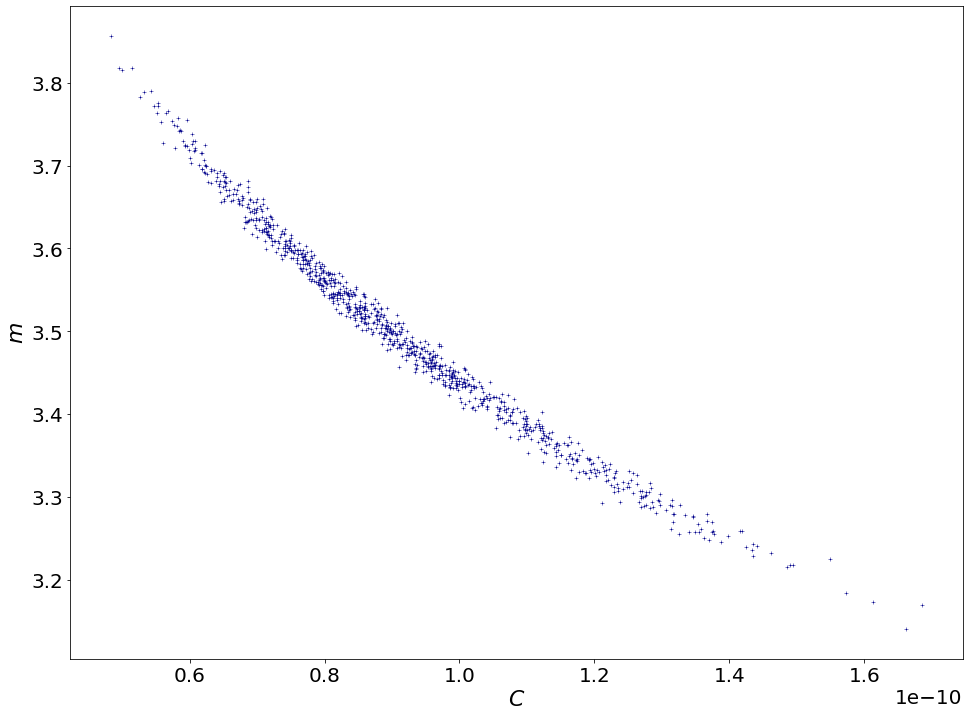

In [56]:
plt.figure(figsize=(16, 12))
plt.rcParams.update({'font.size':22})
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.scatter(training_set.C.values, training_set.m.values,marker='+',   s=20, c = 'darkblue',cmap='viridis', linewidth=0.5)
plt.xlabel('$C$')
plt.ylabel('$m$')
# plt.legend()



plt.show()

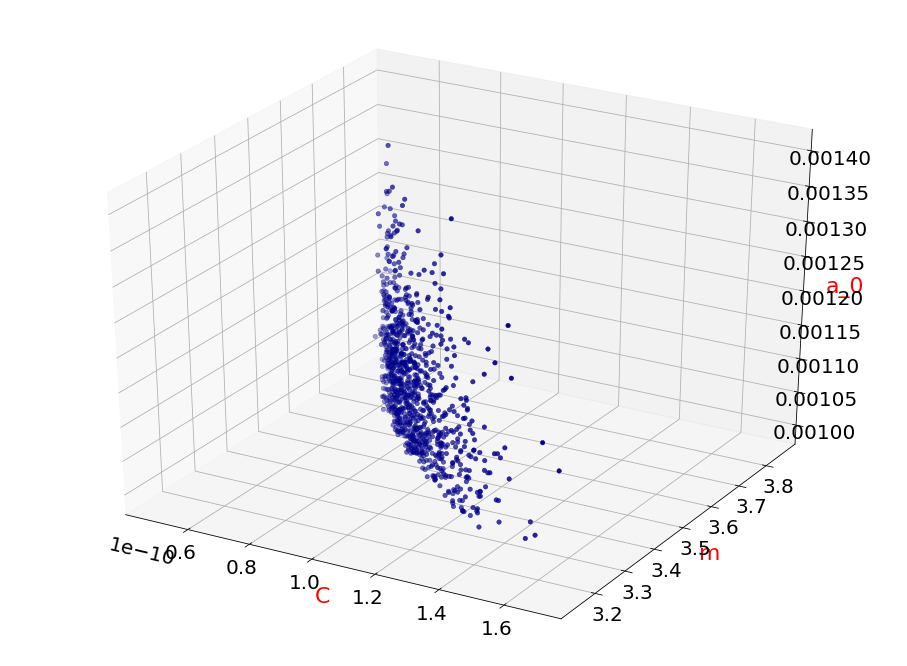

In [60]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib qt
import PyQt5

# %matplotlib notebook 
# fig = plt.figure(figsize=(12, 16))
# ax = fig.add_subplot(111, projection='3d')
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(16, 12))

ax = plt.axes(projection='3d')
ax.scatter3D(training_set.C.values, training_set.m.values, training_set.a_0.values, marker='o',   s=20, zdir='z',c = 'darkblue',cmap='viridis', linewidth=0.5);
# ax.scatter3D(test_set.C.values, test_set.m.values, test_set.a_0.values, marker='o',   s=20, zdir='z',c = 'red',cmap='viridis', linewidth=15);

# for i in range(100): #plot each point + it's index as text above
#     ax.text(test_set.C, test_set.m, test_set.a_0,  'y') 
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

ax.set_xlabel('C', c='r')
ax.set_ylabel('m', c='r')
ax.set_zlabel('a_0', c='r')

plt.show()


# Structuring into dataframes

In [30]:
cols = ['ID', 'cycle'] +  ['gauge' + str(i+1) for i in range(nb_gauges)]+  ['RUL']

utils.build_dataset(training_set,    cols,  nb_gauges = 3, stop_tstar = False, thinning = 500).to_pickle('data_train')
utils.build_dataset(validation_set,  cols,  nb_gauges = 3, stop_tstar = False, thinning = 500).to_pickle('data_val')
utils.build_dataset(test_set,        cols,  nb_gauges = 3, stop_tstar = True,  thinning = 500).to_pickle('data_test')


# Load The structured dataframes

In [62]:
data_train = pd.read_pickle('data_train')
data_val = pd.read_pickle('data_val')
data_test = pd.read_pickle('data_test')


In [63]:
data_train.ix[data_train.ID==1]

,ID,cycle,gauge1,gauge2,gauge3,RUL
0,1,0,0.000684,0.000693,0.000695,68053
1,1,500,0.000684,0.000693,0.000695,67553
2,1,1000,0.000684,0.000693,0.000695,67053
3,1,1500,0.000684,0.000693,0.000695,66553
4,1,2000,0.000684,0.000693,0.000695,66053
...,...,...,...,...,...,...
132,1,66000,0.000095,0.000178,0.000754,2053
133,1,66500,0.000078,0.000112,0.000743,1553
134,1,67000,0.000062,0.000044,0.000721,1053
135,1,67500,0.000047,-0.000022,0.000684,553


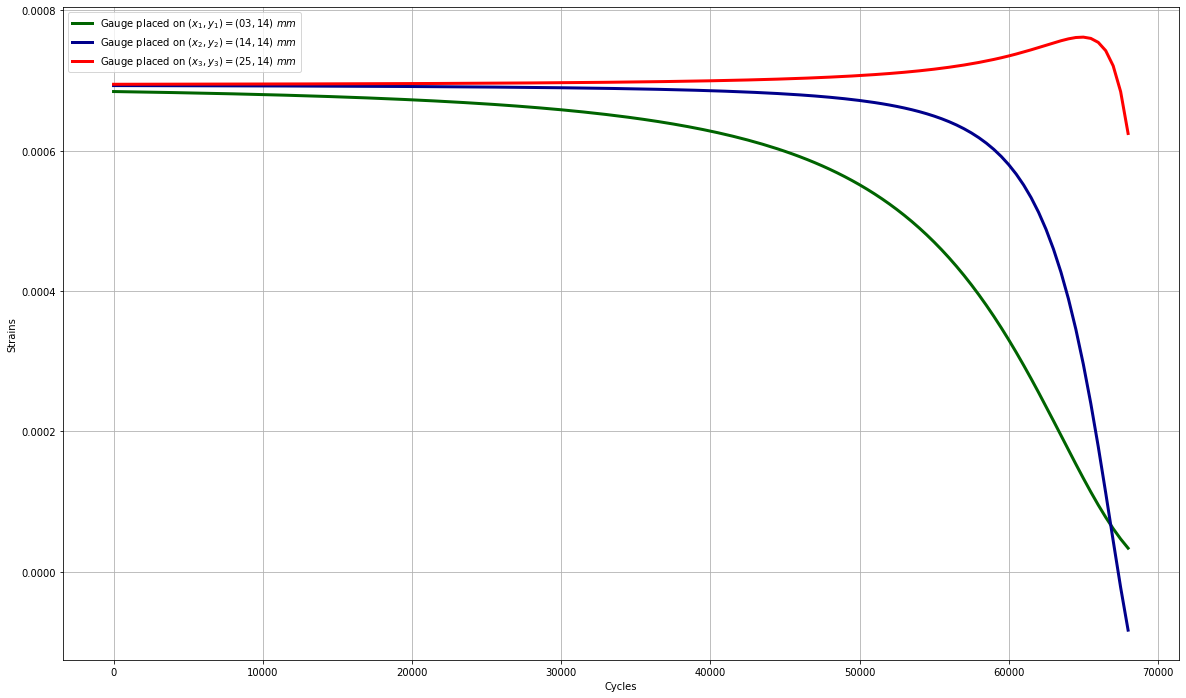

In [64]:
# for k in [0,1,2] :
k = 0
plt.figure(figsize=(20, 12))

plt.plot(data_train.ix[data_train.ID==1].cycle.values,data_train.ix[data_train.ID==1,['gauge' + str(i+1) for i in [0]]], linewidth = 3, color = 'darkgreen', label = 'Gauge placed on $(x_1,y_1) = (03,14) ~ mm$')
plt.plot(data_train.ix[data_train.ID==1].cycle.values,data_train.ix[data_train.ID==1,['gauge' + str(i+1) for i in [1]]], linewidth = 3, color = 'darkblue', label = 'Gauge placed on $(x_2,y_2) = (14,14)~ mm$')
plt.plot(data_train.ix[data_train.ID==1].cycle.values,data_train.ix[data_train.ID==1,['gauge' + str(i+1) for i in [2]]], linewidth = 3, color = 'red', label = 'Gauge placed on $(x_3,y_3) = (25,14)~ mm$')

plt.grid()
plt.legend()

plt.xlabel('Cycles')
plt.ylabel('Strains')
plt.show()
